## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sample_data
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV

In [2]:
organics = pd.read_csv('/content/organics.csv')

## Get info

In [3]:
organics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22223 entries, 0 to 22222
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               22223 non-null  int64  
 1   DemAffl          21138 non-null  float64
 2   DemAge           20715 non-null  float64
 3   DemCluster       21549 non-null  float64
 4   DemClusterGroup  21549 non-null  object 
 5   DemGender        19711 non-null  object 
 6   DemReg           21758 non-null  object 
 7   DemTVReg         21758 non-null  object 
 8   PromClass        22223 non-null  object 
 9   PromSpend        22223 non-null  float64
 10  PromTime         21942 non-null  float64
 11  TargetBuy        22223 non-null  int64  
 12  TargetAmt        22223 non-null  int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 2.2+ MB


## Calculate the percentage of missing values by row

In [4]:
organics.isnull().sum() * 100 / len(organics)

ID                  0.000000
DemAffl             4.882329
DemAge              6.785762
DemCluster          3.032894
DemClusterGroup     3.032894
DemGender          11.303604
DemReg              2.092427
DemTVReg            2.092427
PromClass           0.000000
PromSpend           0.000000
PromTime            1.264456
TargetBuy           0.000000
TargetAmt           0.000000
dtype: float64

## Since 11.30% of the gender entries are missing, I will replace those missing values for gender with "Unknown" category. I will also impute missing values with the mean of their column. Lastly, I will replace the remaining missing categorical data with "unknown"

In [5]:
organics['DemGender'].fillna('U', inplace=True)
organics['DemReg'].fillna('Unknown', inplace=True)
organics['DemTVReg'].fillna('Unknown', inplace=True)
organics['DemClusterGroup'].fillna('U', inplace=True)
organics['DemAffl'].fillna(organics['DemAffl'].mean(), inplace=True)
organics['DemAge'].fillna(organics['DemAge'].mean(), inplace=True)
organics['DemCluster'].fillna(organics['DemCluster'].mean(), inplace=True)
organics['PromTime'].fillna(organics['PromTime'].mean(), inplace=True)

## We see there are no more missing values

In [6]:
organics.isnull().sum()

ID                 0
DemAffl            0
DemAge             0
DemCluster         0
DemClusterGroup    0
DemGender          0
DemReg             0
DemTVReg           0
PromClass          0
PromSpend          0
PromTime           0
TargetBuy          0
TargetAmt          0
dtype: int64

## Question 1: Do customers who buy organic products spend more or less on average than other customers?

In [7]:
organics['PromClass'].value_counts()

Silver      8572
Tin         6487
Gold        6324
Platinum     840
Name: PromClass, dtype: int64

In [8]:
organic_buyers = (organics
                  .groupby('TargetBuy')['PromSpend']
                  .mean()
                  .reset_index())
organic_buyers

,TargetBuy,PromSpend
0,0,4767.247335
1,1,3367.834975


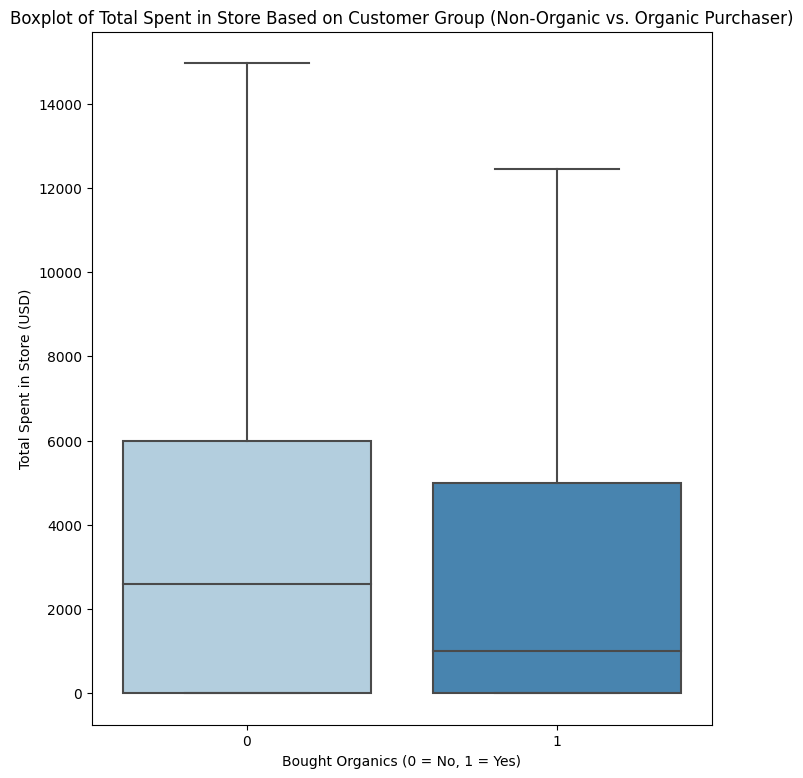

In [9]:
#Make a box plot
plt.figure(figsize=(8, 9))
sns.boxplot(organics,x='TargetBuy', y='PromSpend', showfliers=False, palette="Blues")
plt.title(f'Boxplot of Total Spent in Store Based on Customer Group (Non-Organic vs. Organic Purchaser)')
plt.xlabel('Bought Organics (0 = No, 1 = Yes)')
plt.ylabel('Total Spent in Store (USD)')
plt.show()

## Answer: Customers who purchase organic products tend to spend less than regular customers, so it doesn't make sense for the business to incur a greater cost for the business by stocking more organic products.

## Question 2: are there any noticeable differences in the percentage of customers who purchase organic products across the different loyalty status groups?

In [10]:
organics['PromClass'].value_counts()

Silver      8572
Tin         6487
Gold        6324
Platinum     840
Name: PromClass, dtype: int64

In [11]:
loyalty_status = (organics
                  .groupby('PromClass')['TargetBuy']
                  .sum()
                  .reset_index())
loyalty_status['Total'] = [6324, 840, 8572, 6487]
loyalty_status

,PromClass,TargetBuy,Total
0,Gold,1236,6324
1,Platinum,128,840
2,Silver,2112,8572
3,Tin,2029,6487


In [12]:
loyalty_status['Percent'] = (loyalty_status['TargetBuy'] / loyalty_status['Total']) * 100
loyalty_status

,PromClass,TargetBuy,Total,Percent
0,Gold,1236,6324,19.544592
1,Platinum,128,840,15.238095
2,Silver,2112,8572,24.638357
3,Tin,2029,6487,31.277940


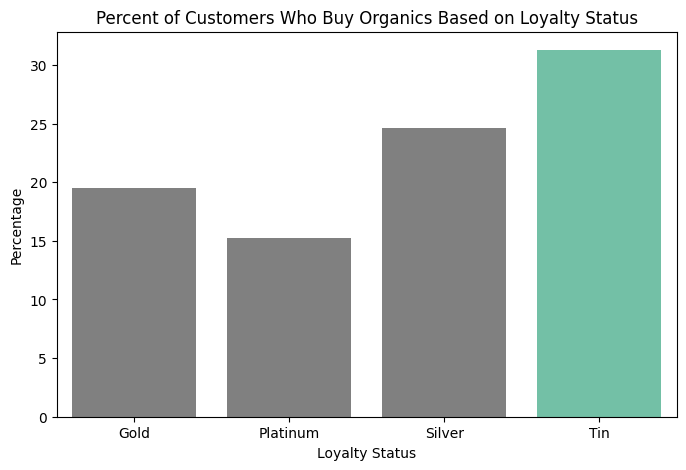

In [13]:
#Make a bar plot
cols = ['gray' if (x < max(loyalty_status.Percent)) else 'mediumaquamarine' for x in loyalty_status.Percent]
plt.figure(figsize=(8, 5))
sns.barplot(loyalty_status, y='Percent', x='PromClass', palette=cols)
plt.title(f'Percent of Customers Who Buy Organics Based on Loyalty Status')
plt.xlabel('Loyalty Status')
plt.ylabel('Percentage')
plt.show()

## From this analysis, we see that the percentage of customers in the "tin" and "silver" loyalty status group who buy organic products is much higher than the percentage of platinum customers.

## Question 3: Let's consider gender

In [14]:
organics['DemGender'].value_counts()

F    12149
M     5815
U     4259
Name: DemGender, dtype: int64

In [15]:
gender = (organics
                  .groupby('DemGender')['TargetBuy']
                  .sum()
                  .reset_index())
gender['Total'] = [12149, 5815, 4259]
gender

,DemGender,TargetBuy,Total
0,F,4205,12149
1,M,966,5815
2,U,334,4259


In [16]:
gender['Percent'] = (gender['TargetBuy'] / gender['Total']) * 100
gender

,DemGender,TargetBuy,Total,Percent
0,F,4205,12149,34.611902
1,M,966,5815,16.612210
2,U,334,4259,7.842216


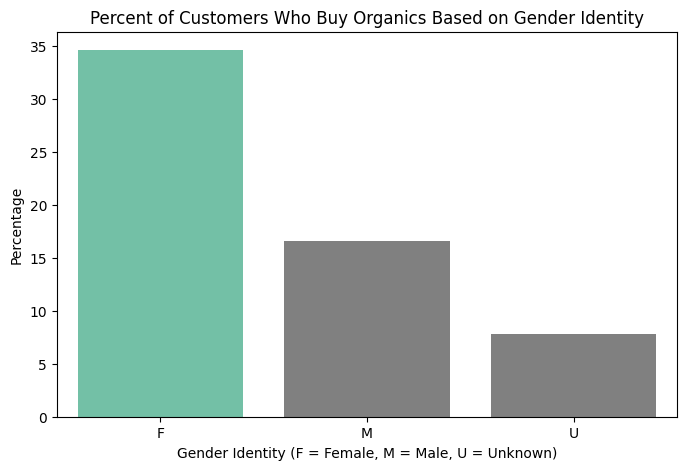

In [17]:
#Make a bar plot
cols = ['gray' if (x < max(gender.Percent)) else 'mediumaquamarine' for x in gender.Percent]
plt.figure(figsize=(8, 5))
sns.barplot(gender, y='Percent', x='DemGender', palette=cols)
plt.title(f'Percent of Customers Who Buy Organics Based on Gender Identity')
plt.xlabel('Gender Identity (F = Female, M = Male, U = Unknown)')
plt.ylabel('Percentage')
plt.show()

## We clearly see that the percentage of customers who buy organic products is much higher for people who identify as female compared to other gender identities

## Now, we will begin making models

## Split the data into train and testing sets

In [18]:
X = organics.drop(['TargetBuy'], axis=1)
X = organics[['DemAffl', 'DemAge', 'DemCluster', 'DemClusterGroup', 'DemGender',
       'DemReg', 'DemTVReg', 'PromClass', 'PromSpend', 'PromTime']]
X = pd.get_dummies(X, columns=['DemClusterGroup', 'DemGender', 'DemReg', 'DemTVReg', 'PromClass'], drop_first=False)

y = organics['TargetBuy']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

X_train.info()
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15556 entries, 19363 to 14155
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   DemAffl                15556 non-null  float64
 1   DemAge                 15556 non-null  float64
 2   DemCluster             15556 non-null  float64
 3   PromSpend              15556 non-null  float64
 4   PromTime               15556 non-null  float64
 5   DemClusterGroup_A      15556 non-null  uint8  
 6   DemClusterGroup_B      15556 non-null  uint8  
 7   DemClusterGroup_C      15556 non-null  uint8  
 8   DemClusterGroup_D      15556 non-null  uint8  
 9   DemClusterGroup_E      15556 non-null  uint8  
 10  DemClusterGroup_F      15556 non-null  uint8  
 11  DemClusterGroup_U      15556 non-null  uint8  
 12  DemGender_F            15556 non-null  uint8  
 13  DemGender_M            15556 non-null  uint8  
 14  DemGender_U            15556 non-null  uint8  
 15

## Make a decision tree

In [19]:
dt = DecisionTreeClassifier(max_depth = 5, min_samples_leaf=100, ccp_alpha = 0)
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0, max_depth=5, min_samples_leaf=100)

In [20]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
# visualize the decision tree
dot_data = export_graphviz(dt, filled=True, rounded=True, feature_names=X.columns, class_names=['0', '1'])
graph = graphviz.Source(dot_data)
graph.render("decision_tree")

'decision_tree.pdf'

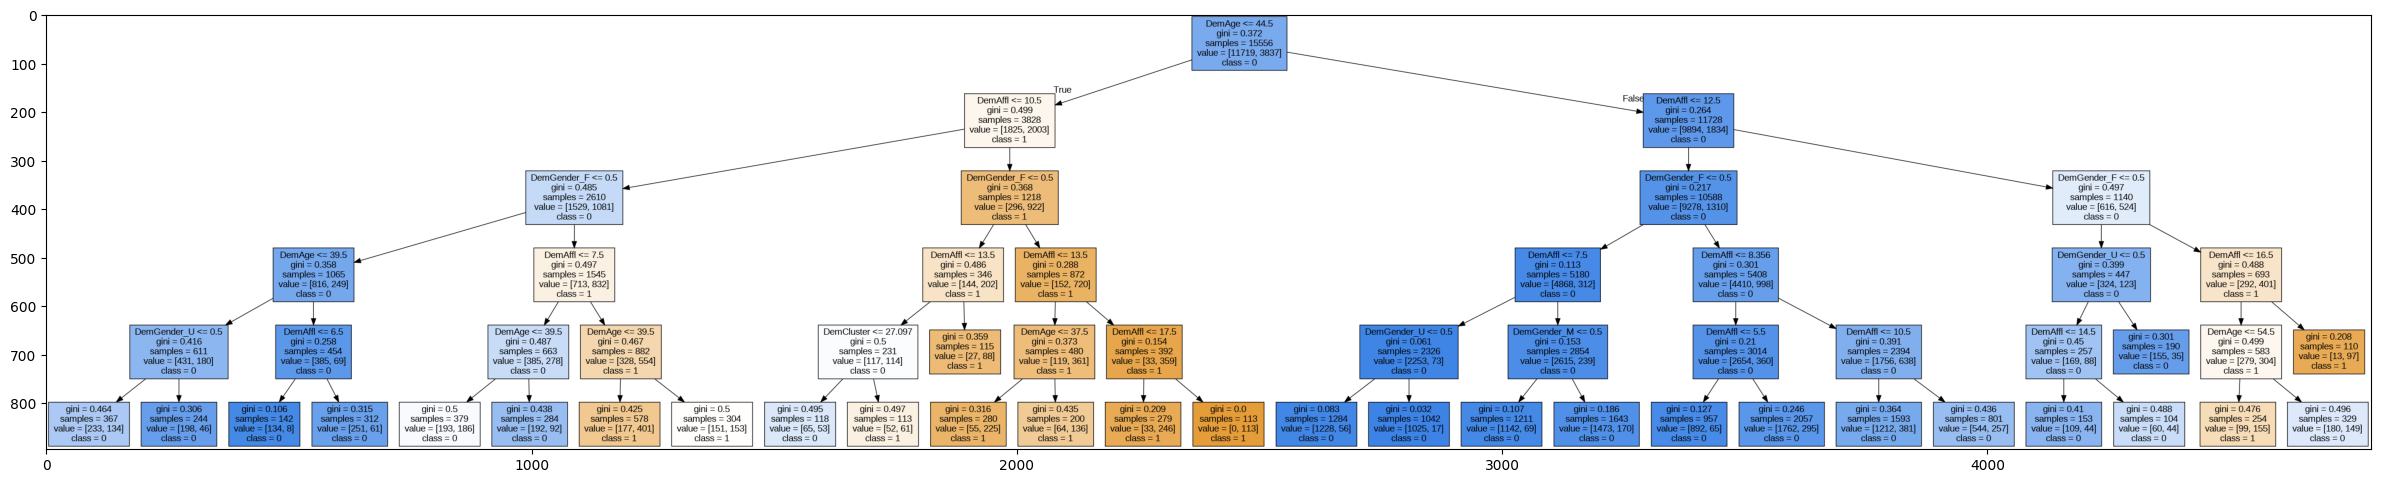

In [21]:
export_graphviz(dt,
                'tree.dot',
                class_names=['0','1'],
                feature_names = X_train.columns,
                filled=True)
! dot -Tpng tree.dot -o tree.png

import matplotlib.pyplot as plt
import cv2
%matplotlib inline
img = cv2.imread('tree.png')
plt.figure(figsize = (30, 40))
plt.imshow(img)

## Make predictions on test and train data. Set the classification threshold to 0.3 to increase recall.

In [22]:
threshold = 0.3
y_pred_train = (dt.predict_proba(X_train)[:, 1] > threshold).astype('float')
y_pred_test = (dt.predict_proba(X_test)[:, 1] > threshold).astype('float')

In [23]:
y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)

In [24]:
y_prob_train = dt.predict_proba(X_train)
y_prob_test = dt.predict_proba(X_test)

In [25]:
# calculate the accuracy, precision, and recall scores
acc_train = accuracy_score(y_train, y_pred_train)
prec_train = precision_score(y_train, y_pred_train)
rec_train = recall_score(y_train, y_pred_train)

# print the scores
print(" -- train set -- ")
print("Accuracy : {:.4f}".format(acc_train))
print("Precision: {:.4f}".format(prec_train))
print("Recall.  : {:.4f}".format(rec_train))
print("")

# calculate the accuracy, precision, and recall scores
acc_test = accuracy_score(y_test, y_pred_test)
prec_test = precision_score(y_test, y_pred_test)
rec_test = recall_score(y_test, y_pred_test)

print(" -- test set -- ")
print("Accuracy : {:.4f}".format(acc_test))
print("Precision: {:.4f}".format(prec_test))
print("Recall.  : {:.4f}".format(rec_test))

 -- train set -- 
Accuracy : 0.8179
Precision: 0.7140
Recall.  : 0.4365

 -- test set -- 
Accuracy : 0.8028
Precision: 0.6763
Recall.  : 0.4059


## Generate a confusion matrix for the training set

In [26]:
conf_matrix = confusion_matrix(y_pred_train, y_train)
print(conf_matrix)

[[11048  2162]
 [  671  1675]]


<Axes: >

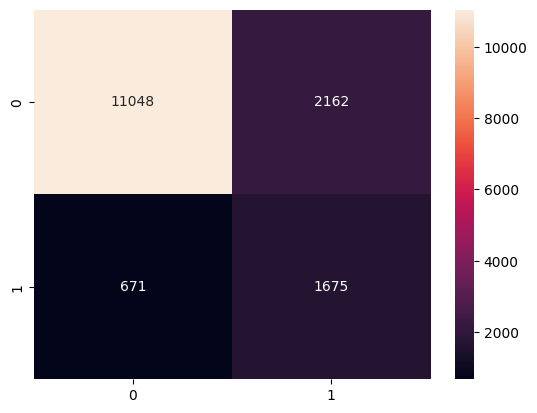

In [27]:
sns.heatmap(conf_matrix, fmt='.5g', annot=True)

## Generate a confusion matrix for the test set

In [28]:
conf_matrix = confusion_matrix(y_pred_test, y_test)
print(conf_matrix)

[[4675  991]
 [ 324  677]]


<Axes: >

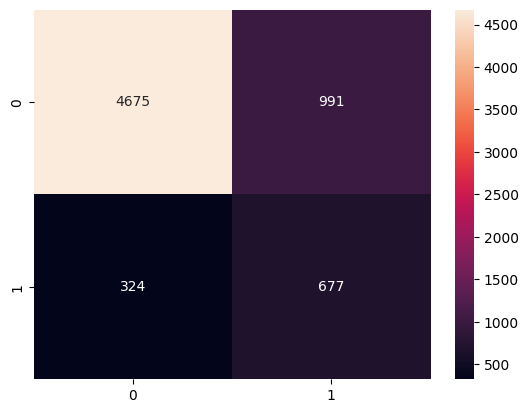

In [29]:
sns.heatmap(conf_matrix, fmt='.5g', annot=True)

## ROC Curve for training set

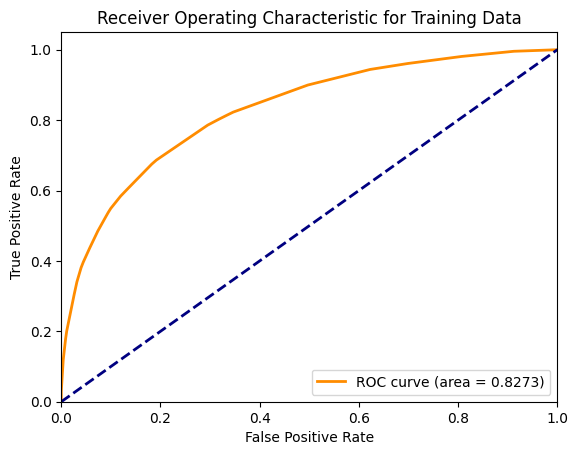

In [30]:
fpr, tpr, thresholds = roc_curve(y_train.astype('category').cat.codes, y_prob_train[:,1])
roc_auc = roc_auc_score(y_train.astype('category').cat.codes, y_prob_train[:,1])

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Training Data')
plt.legend(loc='lower right')
plt.show()

## ROC Curve for test data

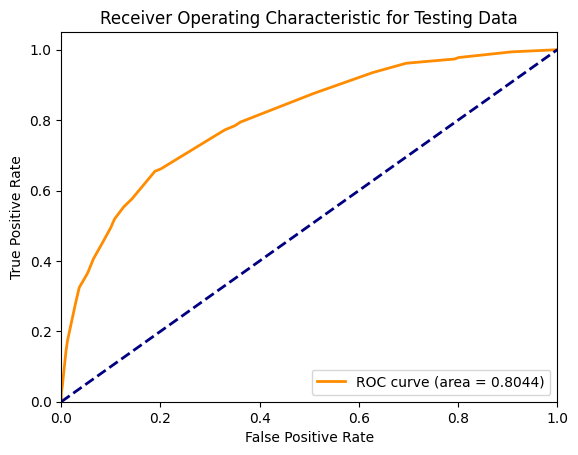

In [31]:
fpr, tpr, thresholds = roc_curve(y_test.astype('category').cat.codes, y_prob_test[:,1])
roc_auc = roc_auc_score(y_test.astype('category').cat.codes, y_prob_test[:,1])
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Testing Data')
plt.legend(loc='lower right')
plt.show()

## Calculate the variable importance

    importance                feature
1     0.479385                 DemAge
0     0.347154                DemAffl
12    0.162125            DemGender_F
14    0.009024            DemGender_U
13    0.001758            DemGender_M
2     0.000554             DemCluster
24    0.000000        DemTVReg_London
25    0.000000      DemTVReg_Midlands
26    0.000000        DemTVReg_N East
27    0.000000        DemTVReg_N Scot
28    0.000000        DemTVReg_N West
29    0.000000    DemTVReg_S & S East
22    0.000000    DemTVReg_C Scotland
30    0.000000        DemTVReg_S West
31    0.000000        DemTVReg_Ulster
32    0.000000       DemTVReg_Unknown
33    0.000000  DemTVReg_Wales & West
34    0.000000     DemTVReg_Yorkshire
35    0.000000         PromClass_Gold
36    0.000000     PromClass_Platinum
37    0.000000       PromClass_Silver
23    0.000000          DemTVReg_East
19    0.000000      DemReg_South West
21    0.000000        DemTVReg_Border
20    0.000000         DemReg_Unknown
18    0.0000

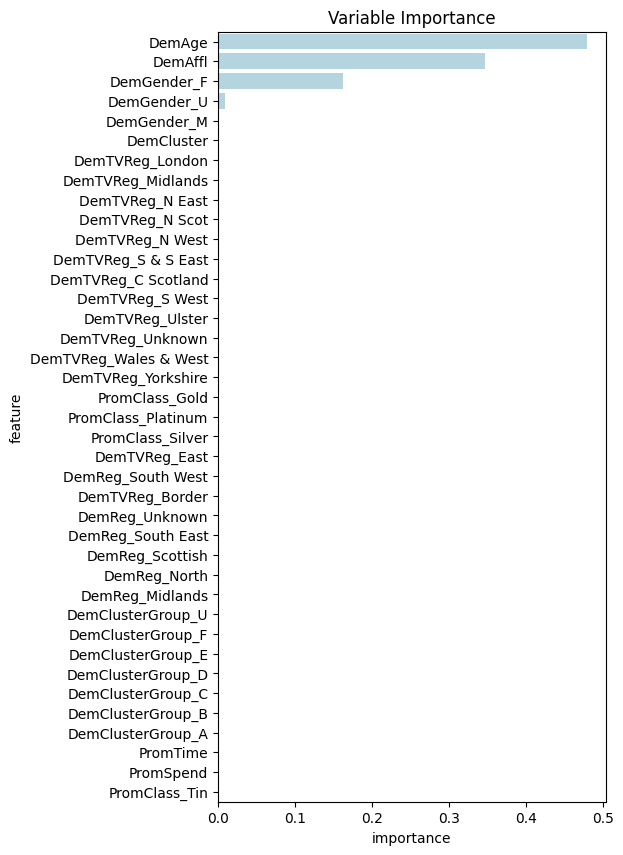

In [32]:
#calculate feature importance
tree_imp = dt.feature_importances_

#create a data frame with feature names

# creating a list of column names
column_values = ['importance']

# creating the dataframe
df = pd.DataFrame(data = tree_imp,
                  columns = column_values)
df['feature']=X.columns

#sort data so features with largest importance values are at the top
df2 = df.sort_values(by=['importance'], ascending=False)

print(df2)

#Create variable importance plot
plt.figure(figsize=(5, 10))
plt.title('Variable Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
sns.barplot(data=df2,
            y=df2['feature'],
            x=df2['importance'], color="lightblue")

plt.show()

## For our second model, let's fit a full logistic regression model

In [33]:
X = organics.drop(['TargetBuy'], axis=1)
X = organics[['DemAffl', 'DemAge', 'DemCluster', 'DemClusterGroup', 'DemGender',
       'DemReg', 'DemTVReg', 'PromClass', 'PromSpend', 'PromTime']]
X = pd.get_dummies(X, columns=['DemClusterGroup', 'DemGender', 'DemReg', 'DemTVReg', 'PromClass'], drop_first=True)

y = organics['TargetBuy']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

X_train.info()
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15556 entries, 19363 to 14155
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   DemAffl                15556 non-null  float64
 1   DemAge                 15556 non-null  float64
 2   DemCluster             15556 non-null  float64
 3   PromSpend              15556 non-null  float64
 4   PromTime               15556 non-null  float64
 5   DemClusterGroup_B      15556 non-null  uint8  
 6   DemClusterGroup_C      15556 non-null  uint8  
 7   DemClusterGroup_D      15556 non-null  uint8  
 8   DemClusterGroup_E      15556 non-null  uint8  
 9   DemClusterGroup_F      15556 non-null  uint8  
 10  DemClusterGroup_U      15556 non-null  uint8  
 11  DemGender_M            15556 non-null  uint8  
 12  DemGender_U            15556 non-null  uint8  
 13  DemReg_North           15556 non-null  uint8  
 14  DemReg_Scottish        15556 non-null  uint8  
 15

In [34]:
#Fit full logistic regression model to examine the significance of the terms
X = X_train
X = sm.add_constant(X)
y=y_train

logit_full = sm.Logit(y, X).fit()

#Print summary
print(logit_full.summary())


Optimization terminated successfully.
         Current function value: 0.428337
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              TargetBuy   No. Observations:                15556
Model:                          Logit   Df Residuals:                    15526
Method:                           MLE   Df Model:                           29
Date:                Sat, 18 Nov 2023   Pseudo R-squ.:                  0.2332
Time:                        16:15:40   Log-Likelihood:                -6663.2
converged:                       True   LL-Null:                       -8690.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.2428   1.14e+06  -2.13e-07      1.000   -2.24e+06    2.24e

In [35]:
# Generate predicted values for training set
pprob = logit_full.predict(X)

# Create predicted category for success using 50% cutoff
psuccess = (pprob > 0.3).astype(int)

# Add new variables to the training data set
X_train['p_success'] = psuccess
X_train['p_prob'] = pprob
X_train['y'] = y_train

X_train.info()


# Generate predicted values for test set

X_test = sm.add_constant(X_test)

pprob_test = logit_full.predict(X_test)

# Create predicted category for success using 50% cutoff
psuccess_test = (pprob_test > 0.3).astype(int)

# Add new variables to the response data set
X_test['p_success'] = psuccess_test
X_test['p_prob'] = pprob_test

X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15556 entries, 19363 to 14155
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   DemAffl                15556 non-null  float64
 1   DemAge                 15556 non-null  float64
 2   DemCluster             15556 non-null  float64
 3   PromSpend              15556 non-null  float64
 4   PromTime               15556 non-null  float64
 5   DemClusterGroup_B      15556 non-null  uint8  
 6   DemClusterGroup_C      15556 non-null  uint8  
 7   DemClusterGroup_D      15556 non-null  uint8  
 8   DemClusterGroup_E      15556 non-null  uint8  
 9   DemClusterGroup_F      15556 non-null  uint8  
 10  DemClusterGroup_U      15556 non-null  uint8  
 11  DemGender_M            15556 non-null  uint8  
 12  DemGender_U            15556 non-null  uint8  
 13  DemReg_North           15556 non-null  uint8  
 14  DemReg_Scottish        15556 non-null  uint8  
 15

In [36]:
# Generate confusion matrix for training set
conf_matrix = confusion_matrix(psuccess, y_train)
print(conf_matrix)

[[9389 1313]
 [2330 2524]]


<Axes: >

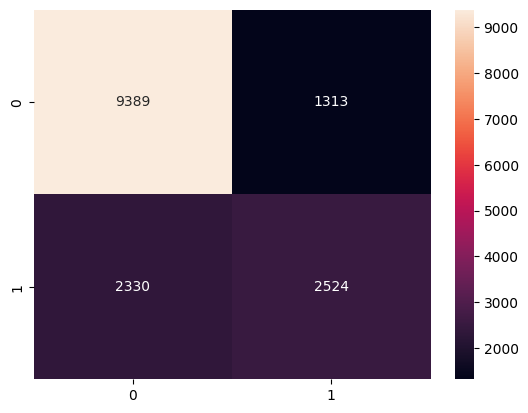

In [37]:
sns.heatmap(conf_matrix, fmt='.5g', annot=True)

In [38]:
# Generate confusion matrix for test set
conf_matrix = confusion_matrix(psuccess_test, y_test)
print(conf_matrix)

[[3976  601]
 [1023 1067]]


<Axes: >

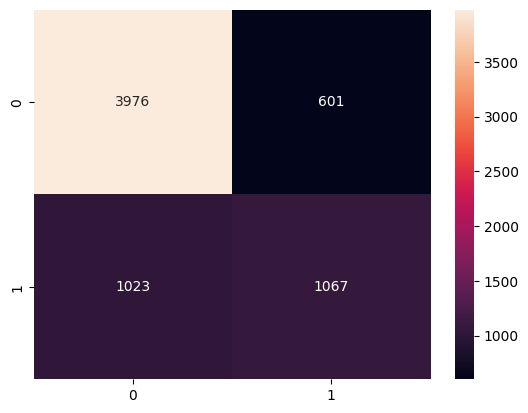

In [39]:
sns.heatmap(conf_matrix, fmt='.5g', annot=True)

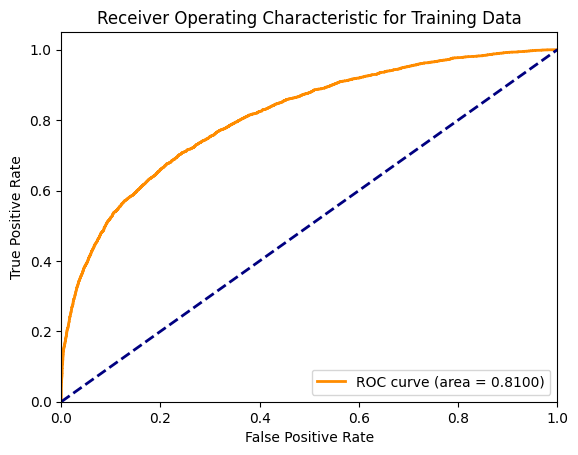

In [40]:
# Generate ROC curve for training data
fpr, tpr, thresholds = roc_curve(y_train.astype('category').cat.codes, pprob)
roc_auc = roc_auc_score(y_train.astype('category').cat.codes, pprob)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Training Data')
plt.legend(loc='lower right')
plt.show()

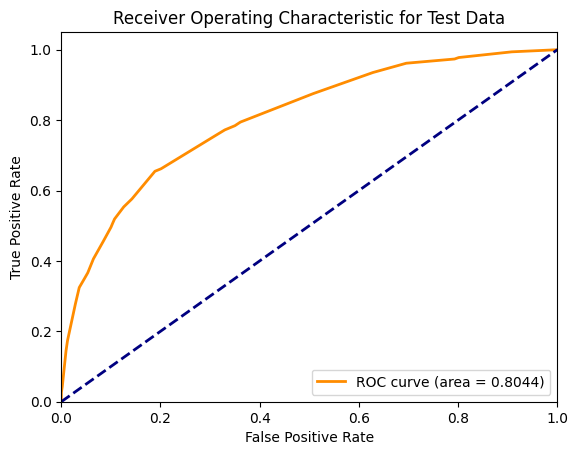

In [41]:
fpr, tpr, thresholds = roc_curve(y_test.astype('category').cat.codes, y_prob_test[:,1])
roc_auc = roc_auc_score(y_test.astype('category').cat.codes, y_prob_test[:,1])
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Test Data')
plt.legend(loc='lower right')
plt.show()

In [42]:
# calculate the accuracy, precision, and recall scores for training
acc_train = accuracy_score(y_train, psuccess)
prec_train = precision_score(y_train, psuccess)
rec_train = recall_score(y_train, psuccess)

# print the scores

print("Accuracy (Train) : {:.4f}".format(acc_train))
print("Precision (Train): {:.4f}".format(prec_train))
print("Recall (Train)  : {:.4f}".format(rec_train))
print("")

# calculate the accuracy, precision, and recall scores for test
acc_test = accuracy_score(y_test, psuccess_test)
prec_test = precision_score(y_test, psuccess_test)
rec_test = recall_score(y_test, psuccess_test)

# print the scores

print("Accuracy (Test) : {:.4f}".format(acc_test))
print("Precision (Test): {:.4f}".format(prec_test))
print("Recall (Test)  : {:.4f}".format(rec_test))
print("")


Accuracy (Train) : 0.7658
Precision (Train): 0.5200
Recall (Train)  : 0.6578

Accuracy (Test) : 0.7564
Precision (Test): 0.5105
Recall (Test)  : 0.6397



## For our third model, let's fit a reduced logistic regression model

In [43]:
# split the data into training and testing sets
X2 = organics.drop(['TargetBuy'], axis=1)
X2 = organics[['DemAffl', 'DemAge', 'DemCluster', 'DemClusterGroup', 'DemGender',
       'DemReg', 'DemTVReg', 'PromClass', 'PromSpend', 'PromTime']]
X2 = pd.get_dummies(X2, columns=['DemClusterGroup', 'DemGender', 'DemReg', 'DemTVReg', 'PromClass'], drop_first=True)

y2 = organics['TargetBuy']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42)

X2_train.info()
y2_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15556 entries, 5426 to 15795
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   DemAffl                15556 non-null  float64
 1   DemAge                 15556 non-null  float64
 2   DemCluster             15556 non-null  float64
 3   PromSpend              15556 non-null  float64
 4   PromTime               15556 non-null  float64
 5   DemClusterGroup_B      15556 non-null  uint8  
 6   DemClusterGroup_C      15556 non-null  uint8  
 7   DemClusterGroup_D      15556 non-null  uint8  
 8   DemClusterGroup_E      15556 non-null  uint8  
 9   DemClusterGroup_F      15556 non-null  uint8  
 10  DemClusterGroup_U      15556 non-null  uint8  
 11  DemGender_M            15556 non-null  uint8  
 12  DemGender_U            15556 non-null  uint8  
 13  DemReg_North           15556 non-null  uint8  
 14  DemReg_Scottish        15556 non-null  uint8  
 15 

In [44]:
#Fit reduced (stepwise) logistic regression model to examine the significance of the terms
X2 = X2_train
X2 = sm.add_constant(X2)
y2=y2_train

logit_step = sm.Logit(y2, X2).fit()

#Print summary
print(logit_step.summary())

Optimization terminated successfully.
         Current function value: 0.436880
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              TargetBuy   No. Observations:                15556
Model:                          Logit   Df Residuals:                    15526
Method:                           MLE   Df Model:                           29
Date:                Sat, 18 Nov 2023   Pseudo R-squ.:                  0.2195
Time:                        16:15:46   Log-Likelihood:                -6796.1
converged:                       True   LL-Null:                       -8707.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.1815        nan        nan        nan         nan         

In [45]:
# Generate predicted values for training set
pprob2 = logit_step.predict(X2)

# Create predicted category for success using 30% cutoff
psuccess2 = (pprob2 > 0.3).astype(int)

# Add new variables to the training data set
X2_train['p_success'] = psuccess2
X2_train['p_prob'] = pprob2
X2_train['y'] = y2_train

X2_train.info()


# Generate predicted values for test set

X2_test = sm.add_constant(X2_test)

pprob2_test = logit_step.predict(X2_test)

# Create predicted category for success using 30% cutoff
psuccess2_test = (pprob2_test > 0.3).astype(int)

# Add new variables to the response data set
X2_test['p_success'] = psuccess2_test
X2_test['p_prob'] = pprob2_test

X2_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15556 entries, 5426 to 15795
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   DemAffl                15556 non-null  float64
 1   DemAge                 15556 non-null  float64
 2   DemCluster             15556 non-null  float64
 3   PromSpend              15556 non-null  float64
 4   PromTime               15556 non-null  float64
 5   DemClusterGroup_B      15556 non-null  uint8  
 6   DemClusterGroup_C      15556 non-null  uint8  
 7   DemClusterGroup_D      15556 non-null  uint8  
 8   DemClusterGroup_E      15556 non-null  uint8  
 9   DemClusterGroup_F      15556 non-null  uint8  
 10  DemClusterGroup_U      15556 non-null  uint8  
 11  DemGender_M            15556 non-null  uint8  
 12  DemGender_U            15556 non-null  uint8  
 13  DemReg_North           15556 non-null  uint8  
 14  DemReg_Scottish        15556 non-null  uint8  
 15 

In [46]:
# Generate confusion matrix for training set
conf_matrix = confusion_matrix(psuccess2, y2_train)
print(conf_matrix)

[[9328 1323]
 [2375 2530]]


<Axes: >

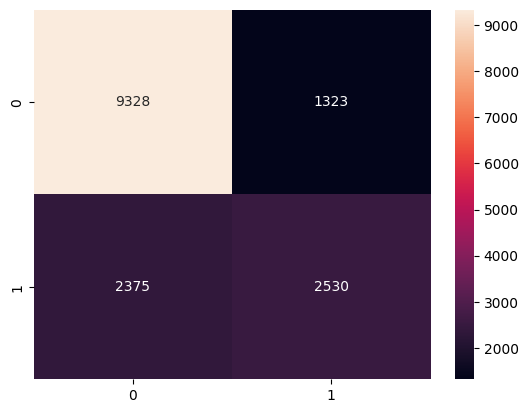

In [47]:
sns.heatmap(conf_matrix, fmt='.5g', annot=True)

In [48]:
# Generate confusion matrix for test set
conf_matrix = confusion_matrix(psuccess2_test, y2_test)
print(conf_matrix)

[[4017  576]
 [ 998 1076]]


<Axes: >

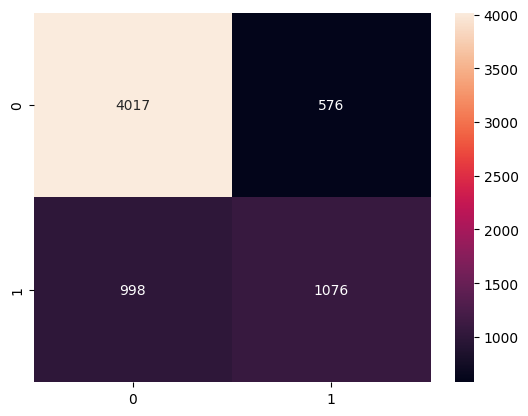

In [49]:
sns.heatmap(conf_matrix, fmt='.5g', annot=True)

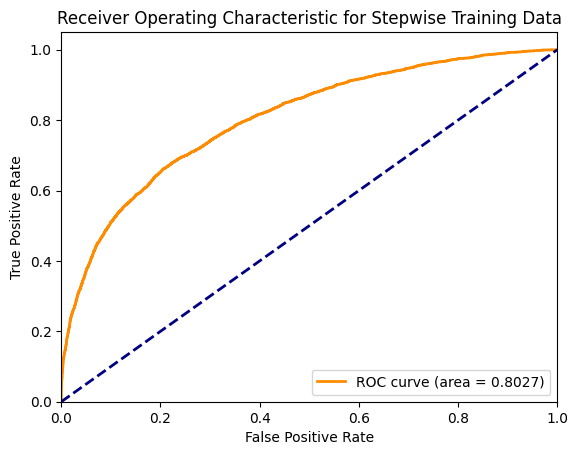

In [50]:
# Generate ROC curve for training data
fpr, tpr, thresholds = roc_curve(y2_train.astype('category').cat.codes, pprob2)
roc_auc = roc_auc_score(y2_train.astype('category').cat.codes, pprob2)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Stepwise Training Data')
plt.legend(loc='lower right')
plt.show()

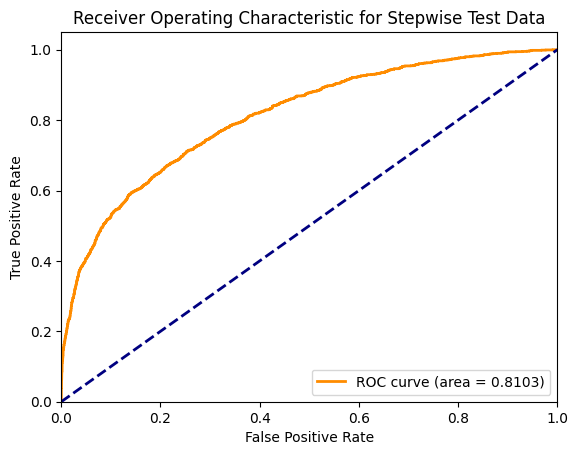

In [51]:
# Generate ROC curve for test data
fpr, tpr, thresholds = roc_curve(y2_test.astype('category').cat.codes, pprob2_test)
roc_auc = roc_auc_score(y2_test.astype('category').cat.codes, pprob2_test)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Stepwise Test Data')
plt.legend(loc='lower right')
plt.show()


In [52]:
# calculate the accuracy, precision, and recall scores
acc_train2 = accuracy_score(y2_train, psuccess2)
prec_train2 = precision_score(y2_train, psuccess2)
rec_train2 = recall_score(y2_train, psuccess2)

# print the scores

print("Accuracy (Train) : {:.4f}".format(acc_train2))
print("Precision (Train): {:.4f}".format(prec_train2))
print("Recall (Train)  : {:.4f}".format(rec_train2))
print("")

# calculate the accuracy, precision, and recall scores
acc_test2 = accuracy_score(y2_test, psuccess2_test)
prec_test2 = precision_score(y2_test, psuccess2_test)
rec_test2 = recall_score(y2_test, psuccess2_test)

# print the scores

print("Accuracy (Test) : {:.4f}".format(acc_test2))
print("Precision (Test): {:.4f}".format(prec_test2))
print("Recall (Test)  : {:.4f}".format(rec_test2))
print("")


Accuracy (Train) : 0.7623
Precision (Train): 0.5158
Recall (Train)  : 0.6566

Accuracy (Test) : 0.7639
Precision (Test): 0.5188
Recall (Test)  : 0.6513



# For our 4th and 5th model, let's use L1 and L2 regularization

In [53]:
X3 = organics.drop(['TargetBuy'], axis=1)
X3 = organics[['DemAffl', 'DemAge', 'DemCluster', 'DemClusterGroup', 'DemGender',
       'DemReg', 'DemTVReg', 'PromClass', 'PromSpend', 'PromTime']]
X3 = pd.get_dummies(X3, columns=['DemClusterGroup', 'DemGender', 'DemReg', 'DemTVReg', 'PromClass'], drop_first=True)

y3 = organics['TargetBuy']
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=12)

X3_train.info()
y3_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15556 entries, 19363 to 14155
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   DemAffl                15556 non-null  float64
 1   DemAge                 15556 non-null  float64
 2   DemCluster             15556 non-null  float64
 3   PromSpend              15556 non-null  float64
 4   PromTime               15556 non-null  float64
 5   DemClusterGroup_B      15556 non-null  uint8  
 6   DemClusterGroup_C      15556 non-null  uint8  
 7   DemClusterGroup_D      15556 non-null  uint8  
 8   DemClusterGroup_E      15556 non-null  uint8  
 9   DemClusterGroup_F      15556 non-null  uint8  
 10  DemClusterGroup_U      15556 non-null  uint8  
 11  DemGender_M            15556 non-null  uint8  
 12  DemGender_U            15556 non-null  uint8  
 13  DemReg_North           15556 non-null  uint8  
 14  DemReg_Scottish        15556 non-null  uint8  
 15

In [54]:
# Create an Instance of Logistic Regression for LASSO Selection using c = 0.1

lr_l1_1 = LogisticRegression(penalty='l1', solver='liblinear', C=0.1)

# fit the models to the training data
lr_l1_1.fit(X3_train, y3_train)

# Create an Instance of Logistic Regression for Ridge Regression (L2 regularization)
lr_l2 = LogisticRegression(penalty='l2', solver='liblinear')

# fit the models to the training data
lr_l2.fit(X3_train, y3_train)

LogisticRegression(solver='liblinear')

In [55]:
# function for model coefficents
def rpt_model_variables(model):
    # Get the intercept term
    intercept = model.intercept_

    # Access the coefficients (weights) of the model, i rounded them
    coefficients = np.round(model.coef_[0],decimals=4)

    # Create DataFrames for intercept and coefficients
    #df_intercept = pd.DataFrame({'feature': ['Intercept'], 'coefficient': [intercept[0]]})
    df_coefficients = pd.DataFrame({'feature': X3.columns, 'coefficient': coefficients})
    df_coefficients['abs_coefficient'] = df_coefficients['coefficient'].abs()
    df_coefficients.sort_values(by='abs_coefficient', ascending=False, inplace=True)

    # if you want to add intercept to table
    #df_model = pd.concat([df_intercept, df_coefficients]).reset_index(drop=True)

    # Print the DataFrame
    print(df_coefficients)

    return df_coefficients

df_coefficients1 = rpt_model_variables(lr_l1_1)
df_coefficients2 = rpt_model_variables(lr_l2)

                  feature  coefficient  abs_coefficient
12            DemGender_U      -1.7350           1.7350
11            DemGender_M      -0.9790           0.9790
0                 DemAffl       0.2542           0.2542
13           DemReg_North      -0.0975           0.0975
30     DemTVReg_Yorkshire      -0.0651           0.0651
1                  DemAge      -0.0543           0.0543
29  DemTVReg_Wales & West       0.0512           0.0512
32       PromClass_Silver      -0.0473           0.0473
26        DemTVReg_S West       0.0450           0.0450
15      DemReg_South East      -0.0376           0.0376
6       DemClusterGroup_C       0.0373           0.0373
7       DemClusterGroup_D      -0.0337           0.0337
33          PromClass_Tin      -0.0167           0.0167
16      DemReg_South West       0.0112           0.0112
21      DemTVReg_Midlands      -0.0054           0.0054
25    DemTVReg_S & S East      -0.0014           0.0014
2              DemCluster       0.0004          

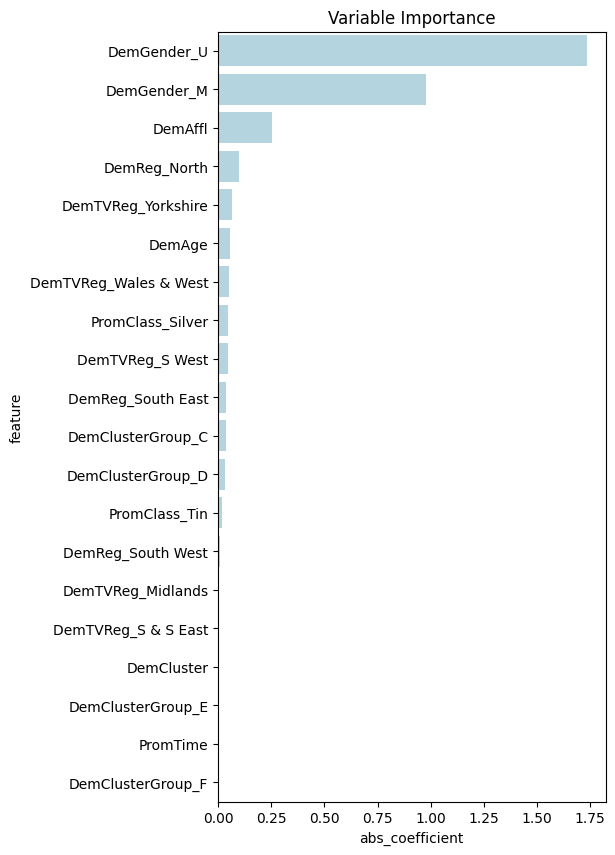

-- rejected --
 DemClusterGroup_U
 DemClusterGroup_B
 PromClass_Platinum
 PromSpend
 DemTVReg_Unknown
 DemTVReg_Ulster
 DemTVReg_N Scot
 DemTVReg_N West
 DemReg_Scottish
 DemTVReg_N East
 DemTVReg_London
 DemTVReg_East
 DemTVReg_C Scotland
 DemReg_Unknown


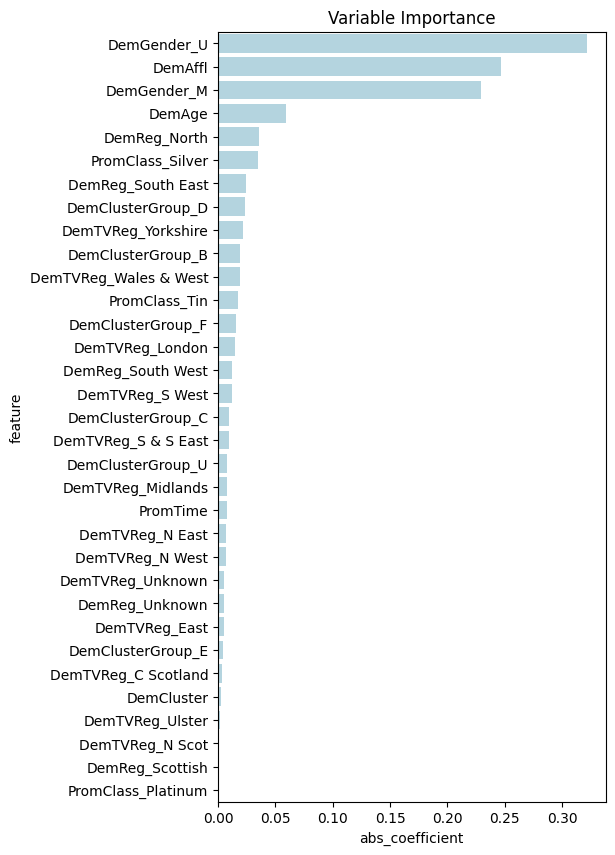

-- rejected --
 PromSpend


In [56]:
# plot variable importance
def plot_variable_imp(df_coef):
  df_plt = df_coef[df_coef['abs_coefficient'] != 0]
  reject_vars = df_coef[df_coef['abs_coefficient'] == 0]['feature'].tolist()

  plt.figure(figsize=(5, 10))
  plt.title('Variable Importance')
  plt.xlabel('Coefficient')
  plt.ylabel('Feature')
  sns.barplot(data=df_plt,
                     y=df_plt['feature'],
                     x=df_plt['abs_coefficient'], color="lightblue")

  plt.show()
  print("-- rejected --")
  for i in reject_vars:
    print(f" {i}")

plot_variable_imp(df_coefficients1)
plot_variable_imp(df_coefficients2)

## Use a threshold of 0.3 to classify as positive, which is what we used for the other models

In [57]:
threshold = 0.3
y_pred_train = (lr_l1_1.predict_proba(X3_train)[:, 1] > threshold).astype('float')
y_pred_test = (lr_l1_1.predict_proba(X3_test)[:, 1]  > threshold).astype('float')
y_proba_train = lr_l1_1.predict_proba(X3_train)
y_proba_test = lr_l1_1.predict_proba(X3_test)


y_pred_train2 = (lr_l2.predict_proba(X3_train)[:, 1] > threshold).astype('float')
y_pred_test2 = (lr_l2.predict_proba(X3_test)[:, 1] > threshold).astype('float')
y_proba_train2 = lr_l2.predict_proba(X3_train)
y_proba_test2 = lr_l2.predict_proba(X3_test)

## L1 with c = 0.1

In [58]:
# calculate the accuracy, precision, and recall scores
acc3_train = accuracy_score(y3_train, y_pred_train)
prec3_train = precision_score(y3_train, y_pred_train)
rec3_train = recall_score(y3_train, y_pred_train)
auc3_train = roc_auc_score(y3_train, y_proba_train[:,1])

# print the scores
print(" -- train set -- ")
print("Accuracy : {:.4f}".format(acc3_train))
print("Precision: {:.4f}".format(prec3_train))
print("Recall.  : {:.4f}".format(rec3_train))
print("AUC      : {:.4f}".format(auc3_train))
print("")

# calculate the accuracy, precision, and recall scores
acc3_test = accuracy_score(y3_test, y_pred_test)
prec3_test = precision_score(y3_test, y_pred_test)
rec3_test = recall_score(y3_test, y_pred_test)
auc3_test = roc_auc_score(y3_test, y_proba_test[:,1])

print(" -- test set -- ")
print("Accuracy : {:.4f}".format(acc3_test))
print("Precision: {:.4f}".format(prec3_test))
print("Recall.  : {:.4f}".format(rec3_test))
print("AUC      : {:.4f}".format(auc3_test))

 -- train set -- 
Accuracy : 0.7661
Precision: 0.5204
Recall.  : 0.6586
AUC      : 0.8093

 -- test set -- 
Accuracy : 0.7549
Precision: 0.5081
Recall.  : 0.6409
AUC      : 0.7944


In [59]:
# Generate confusion matrix for training set
conf_matrix = confusion_matrix(y_pred_train, y3_train)
print(conf_matrix)

[[9390 1310]
 [2329 2527]]


<Axes: >

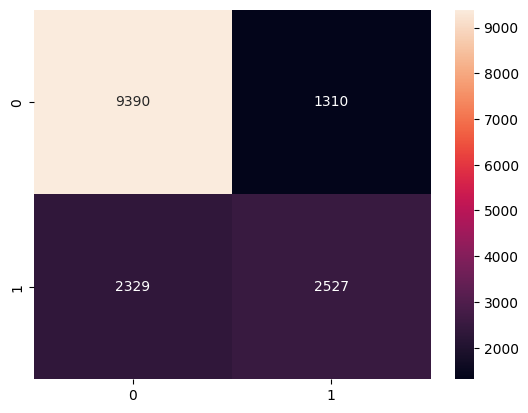

In [60]:
sns.heatmap(conf_matrix, fmt='.5g', annot=True)

In [61]:
# Generate confusion matrix for test set
conf_matrix = confusion_matrix(y_pred_test, y3_test)
print(conf_matrix)

[[3964  599]
 [1035 1069]]


<Axes: >

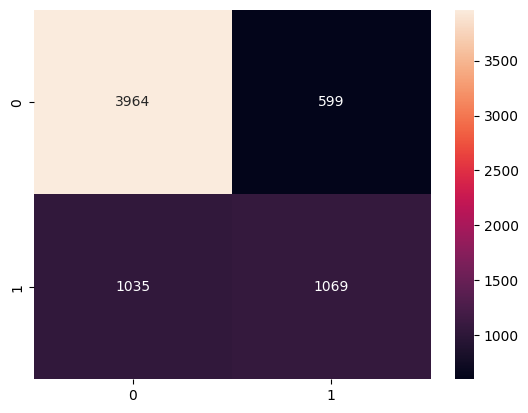

In [62]:
sns.heatmap(conf_matrix, fmt='.5g', annot=True)

## ROC Curves

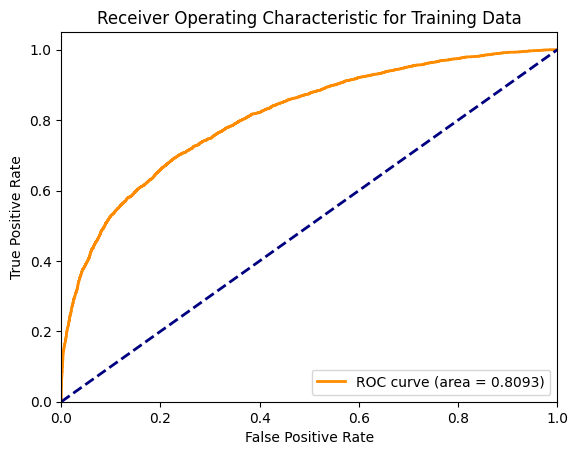

In [63]:
fpr, tpr, thresholds = roc_curve(y3_train.astype('category').cat.codes, y_proba_train[:,1])
roc_auc = roc_auc_score(y3_train.astype('category').cat.codes, y_proba_train[:,1])

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Training Data')
plt.legend(loc='lower right')
plt.show()

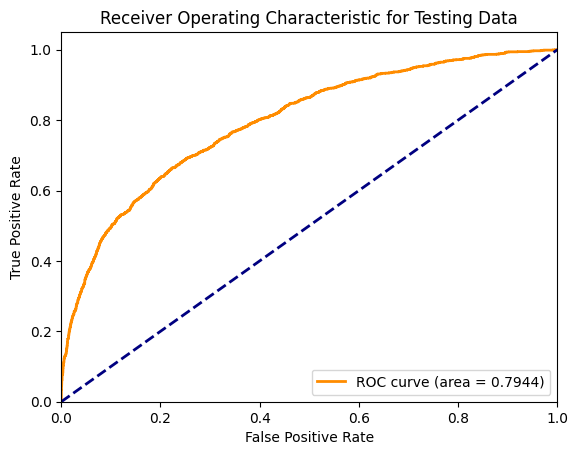

In [64]:
fpr, tpr, thresholds = roc_curve(y3_test.astype('category').cat.codes, y_proba_test[:,1])
roc_auc = roc_auc_score(y3_test.astype('category').cat.codes, y_proba_test[:,1])

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Testing Data')
plt.legend(loc='lower right')
plt.show()

## Lastly, let's look at L2 Regularization

In [65]:
# calculate the accuracy, precision, and recall scores
acc3_train2 = accuracy_score(y3_train, y_pred_train2)
prec3_train2 = precision_score(y3_train, y_pred_train2)
rec3_train2 = recall_score(y3_train, y_pred_train2)
auc3_train2 = roc_auc_score(y3_train, y_proba_train2[:,1])

# print the scores
print(" -- train set -- ")
print("Accuracy : {:.4f}".format(acc3_train2))
print("Precision: {:.4f}".format(prec3_train2))
print("Recall.  : {:.4f}".format(rec3_train2))
print("AUC      : {:.4f}".format(auc3_train2))
print("")

# calculate the accuracy, precision, and recall scores
acc3_test2 = accuracy_score(y3_test, y_pred_test2)
prec3_test2 = precision_score(y3_test, y_pred_test2)
rec3_test2 = recall_score(y3_test, y_pred_test2)
auc3_test2 = roc_auc_score(y3_test, y_proba_test2[:,1])

print(" -- test set -- ")
print("Accuracy : {:.4f}".format(acc3_test2))
print("Precision: {:.4f}".format(prec3_test2))
print("Recall.  : {:.4f}".format(rec3_test2))
print("AUC      : {:.4f}".format(auc3_test2))

 -- train set -- 
Accuracy : 0.7594
Precision: 0.5100
Recall.  : 0.6323
AUC      : 0.7837

 -- test set -- 
Accuracy : 0.7482
Precision: 0.4974
Recall.  : 0.6211
AUC      : 0.7684


In [66]:
# Generate confusion matrix for training set
conf_matrix = confusion_matrix(y_pred_train2, y3_train)
print(conf_matrix)

[[9388 1411]
 [2331 2426]]


<Axes: >

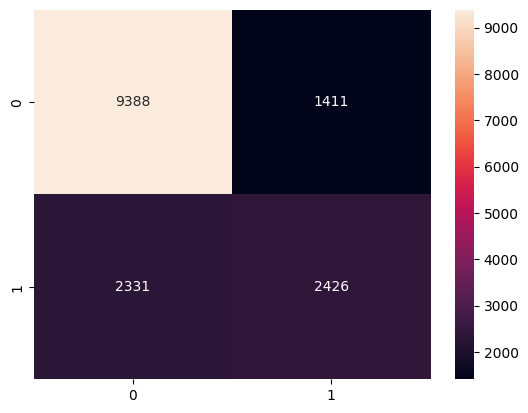

In [67]:
sns.heatmap(conf_matrix, fmt='.5g', annot=True)

In [68]:
# Generate confusion matrix for training set
conf_matrix = confusion_matrix(y_pred_test2, y3_test)
print(conf_matrix)

[[3952  632]
 [1047 1036]]


<Axes: >

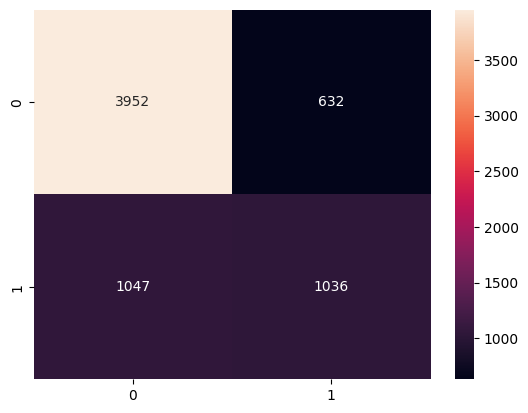

In [69]:
sns.heatmap(conf_matrix, fmt='.5g', annot=True)

## ROC Curves

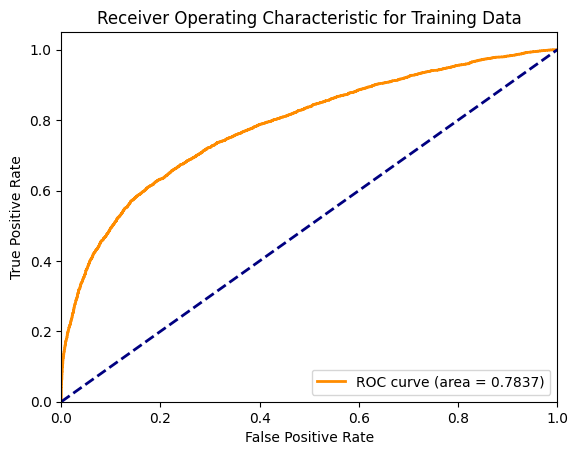

In [70]:
fpr, tpr, thresholds = roc_curve(y3_train.astype('category').cat.codes, y_proba_train2[:,1])
roc_auc = roc_auc_score(y3_train.astype('category').cat.codes, y_proba_train2[:,1])

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Training Data')
plt.legend(loc='lower right')
plt.show()

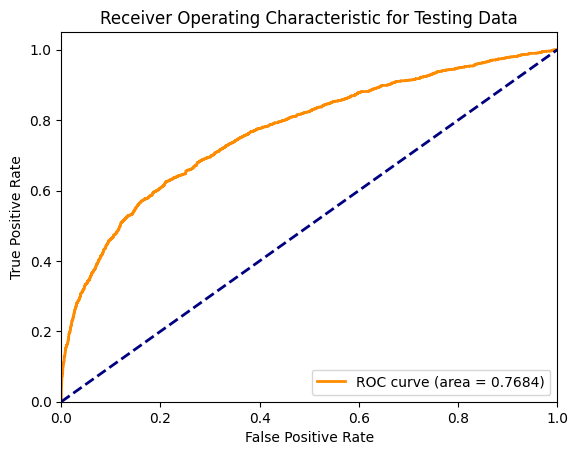

In [71]:
fpr, tpr, thresholds = roc_curve(y3_test.astype('category').cat.codes, y_proba_test2[:,1])
roc_auc = roc_auc_score(y3_test.astype('category').cat.codes, y_proba_test2[:,1])

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Testing Data')
plt.legend(loc='lower right')
plt.show()

## Looking at all the models, I will use the decision tree to score the new data, as it is the simplist model and performs very well.

In [72]:
new_organics = pd.read_csv('/content/New_organics.csv')

In [73]:
new_organics.head()

,ID,DemAffl,DemAge,DemCluster,DemClusterGroup,DemGender,DemReg,DemTVReg,PromClass,PromSpend,PromTime
0,1,6,46,27,D,F,South East,London,Tin,0.01,8
1,2,10,39,12,B,M,Midlands,Ulster,Tin,0.01,5
2,3,7,75,12,B,M,Midlands,East,Silver,4000.00,7
3,4,7,72,12,B,F,Midlands,Ulster,Silver,1250.00,23
4,5,7,43,53,F,M,North,N West,Tin,0.01,5


In [74]:
X = new_organics[['DemAffl', 'DemAge', 'DemCluster', 'DemClusterGroup', 'DemGender',
       'DemReg', 'DemTVReg', 'PromClass', 'PromSpend', 'PromTime']]
X = pd.get_dummies(X, columns=['DemClusterGroup', 'DemGender', 'DemReg', 'DemTVReg', 'PromClass'], drop_first=False)

In [75]:
# New columns to be added
DemClusterGroup_U = 0

# Inserting the column at the
# beginning in the DataFrame
X.insert(loc = 11,
        column = 'DemClusterGroup_U',
       value = DemClusterGroup_U)

DemReg_Unknown = 0
X.insert(loc = 20,
          column = 'DemReg_Unknown',
          value = DemReg_Unknown)

DemTVReg_Border = 0
X.insert(loc = 21,
          column = 'DemTVReg_Border',
          value = DemTVReg_Border)

DemTVReg_Unknown = 0
X.insert(loc = 32,
          column = 'DemTVReg_Unknown',
          value = DemTVReg_Unknown)

In [76]:
Scored_probs = dt.predict_proba(X)

In [77]:
threshold = 0.3
Scored_class = (Scored_probs[:, 1] > threshold).astype('float')

In [78]:
X['PRED_BUY'] = Scored_class
X['PROB_PRED_BUY']= Scored_probs[:,1]

In [79]:
predicted_probabilities_new_customers = X

In [80]:
X

,DemAffl,DemAge,DemCluster,PromSpend,PromTime,DemClusterGroup_A,DemClusterGroup_B,DemClusterGroup_C,DemClusterGroup_D,DemClusterGroup_E,...,DemTVReg_Ulster,DemTVReg_Unknown,DemTVReg_Wales & West,DemTVReg_Yorkshire,PromClass_Gold,PromClass_Platinum,PromClass_Silver,PromClass_Tin,PRED_BUY,PROB_PRED_BUY
0,6,46,27,0.01,8,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0.0,0.143413
1,10,39,12,0.01,5,0,1,0,0,0,...,1,0,0,0,0,0,0,1,1.0,0.365123
2,7,75,12,4000.00,7,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0.0,0.043614
3,7,72,12,1250.00,23,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0.0,0.143413
4,7,43,53,0.01,5,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0.0,0.195513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,3,59,12,12000.00,4,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0.0,0.067921
146,8,69,16,14400.00,8,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0.0,0.103469
147,7,27,52,0.01,4,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1.0,0.490765
148,10,63,14,3000.00,7,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0.0,0.103469


In [81]:
X['PRED_BUY'].value_counts()

0.0    110
1.0     40
Name: PRED_BUY, dtype: int64

## Our decision tree model predicts that 40/150 of the customers in the new dataset will make an organic purchase, which is reasonable

## Export our predictions to Excel

In [82]:
predicted_probabilities_new_customers.to_excel('Jack_Null_Project_3_Scored.xlsx')